# Chapter 7: Sampling


In [1]:
library(tidyverse)
library(ggplot2)
library(knitr)
library(cowplot)
theme_set(theme_minimal(base_size = 14))
set.seed(123456)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Table 7.1

In [2]:
# load the NHANES data library
library(NHANES)

# create a NHANES dataset without duplicated IDs
NHANES <-
  NHANES %>%
  distinct(ID, .keep_all = TRUE)

#create a dataset of only adults
NHANES_adult <-
  NHANES %>%
  filter(
    !is.na(Height),
    Age >= 18
  )

# sample 50 individuals from NHANES dataset
sample_df <- data.frame(sampnum=seq(5), sampleMean=0, sampleSD=0)

for (i in 1:5){
  exampleSample <-
    NHANES_adult %>%
    sample_n(50) %>%
    pull(Height)
  sample_df$sampleMean[i] <- mean(exampleSample)
  sample_df$sampleSD[i] <- sd(exampleSample)
}
sample_df <- sample_df %>%
  dplyr::select(-sampnum)
kable(sample_df, caption='Example means and standard deviations for several samples of Height variable from NARPS')



Table: Example means and standard deviations for several samples of Height variable from NARPS

| sampleMean|  sampleSD|
|----------:|---------:|
|    165.866| 11.267356|
|    168.416|  9.517918|
|    166.988|  9.133000|
|    166.738|  9.768042|
|    166.864| 10.517891|

## Figure 7.1


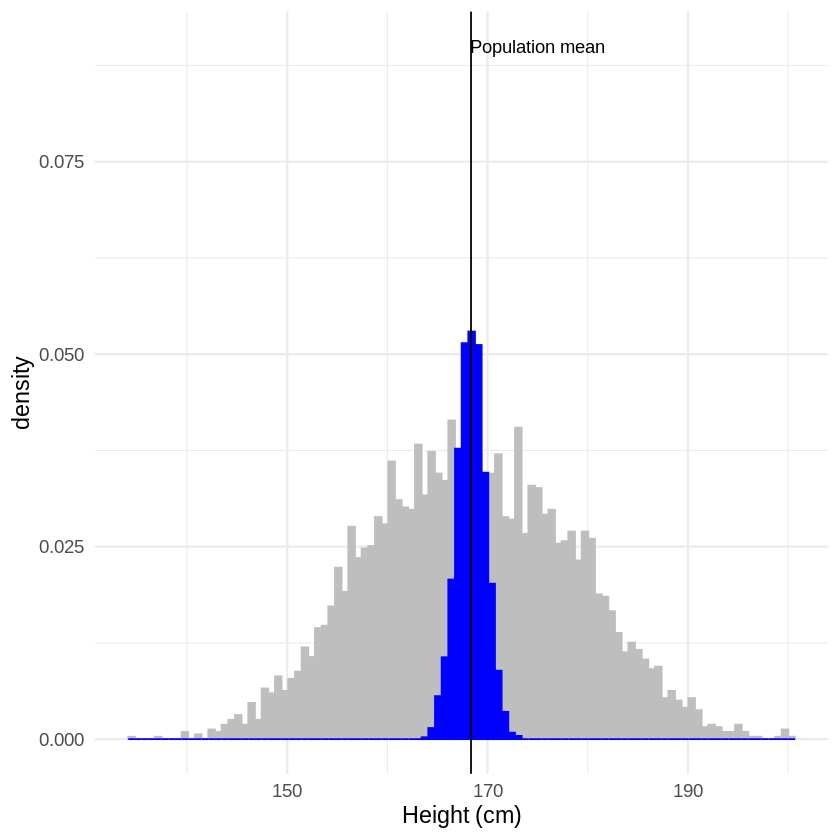

In [5]:
# compute sample means across 5000 samples from NHANES data
sampSize <- 50 # size of sample
nsamps <- 5000 # number of samples we will take

# set up variable to store all of the results
sampMeans <- array(NA, nsamps)

# Loop through and repeatedly sample and compute the mean
for (i in 1:nsamps) {
  NHANES_sample <- sample_n(NHANES_adult, sampSize)
  sampMeans[i] <- mean(NHANES_sample$Height)
}

sampMeans_df <- tibble(sampMeans = sampMeans)

sampMeans_df %>%
  ggplot(aes(sampMeans)) +
  geom_histogram(
    data = NHANES_adult,
    aes(Height, after_stat(density)),
    bins = 100, col = "gray", fill = "gray"
  ) +
  geom_histogram(
    aes(y = ..density.. * 0.2),
    bins = 100,
    col = "blue", fill = "blue"
  ) +
  geom_vline(xintercept = mean(NHANES_adult$Height)) +
  annotate(
    "text",
    x = 175,
    y = .09,
    label = "Population mean"
  ) +
  labs(
      x = "Height (cm)"
  )

## Figure 7.2

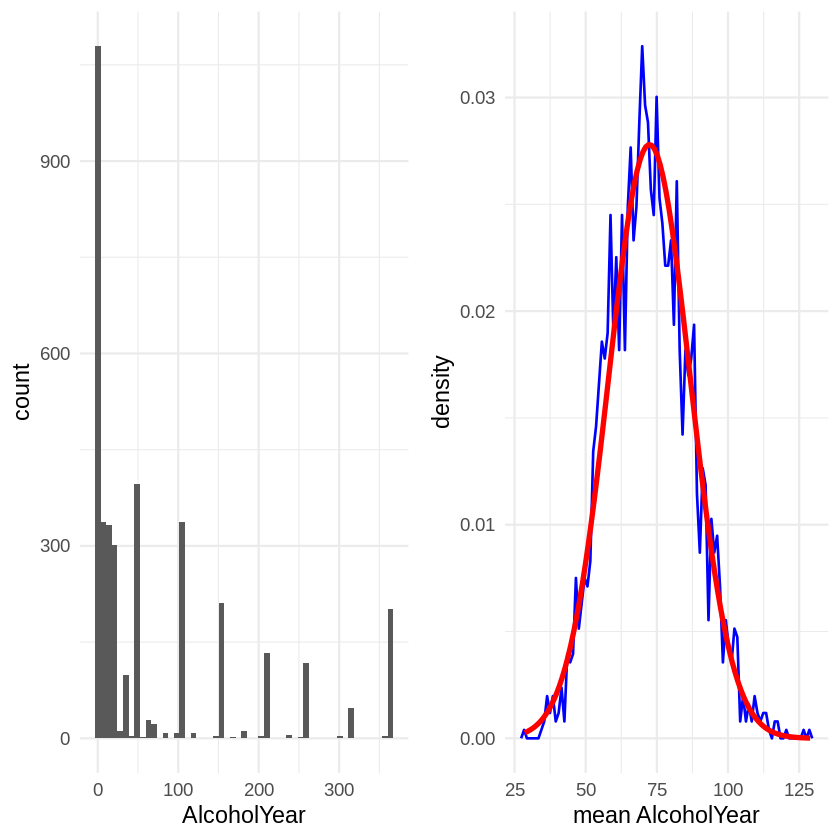

In [6]:
# create sampling distribution function

get_sampling_dist <- function(sampSize, nsamps = 2500) {
  sampMeansFull <- array(NA, nsamps)
  NHANES_clean <- NHANES %>%
    drop_na(AlcoholYear)

  for (i in 1:nsamps) {
    NHANES_sample <- sample_n(NHANES_clean, sampSize)
    sampMeansFull[i] <- mean(NHANES_sample$AlcoholYear)
  }
  sampMeansFullDf <- data.frame(sampMeans = sampMeansFull)

  p2 <- ggplot(sampMeansFullDf, aes(sampMeans)) +
    geom_freqpoly(aes(y = after_stat(density)), bins = 100, color = "blue", linewidth = 0.75) +
    stat_function(
      fun = dnorm, n = 100,
      args = list(
        mean = mean(sampMeansFull),
        sd = sd(sampMeansFull)
      ), size = 1.5, color = "red"
    ) +
    xlab("mean AlcoholYear")
  return(p2)
}

NHANES_cleanAlc <- NHANES %>%
  drop_na(AlcoholYear)
p1 <- ggplot(NHANES_cleanAlc, aes(AlcoholYear)) +
  geom_histogram(binwidth = 7)

p2 <- get_sampling_dist(50)
plot_grid(p1,p2)